In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

2025-11-24 15:35:51.938071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('/Users/Ptanner/ml_projects/uci_eletric_power_consumption_rnn/data/hourly_mean_global_active_power.csv')
df.head()

,DateTime,Global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [4]:
# hourly_mean.set_index('DateTime', inplace=True)
df.set_index = pd.to_datetime(df['DateTime'])
df.head()


,DateTime,Global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [5]:
# df.drop(columns=['DateTime'], inplace=True)

(34589,)

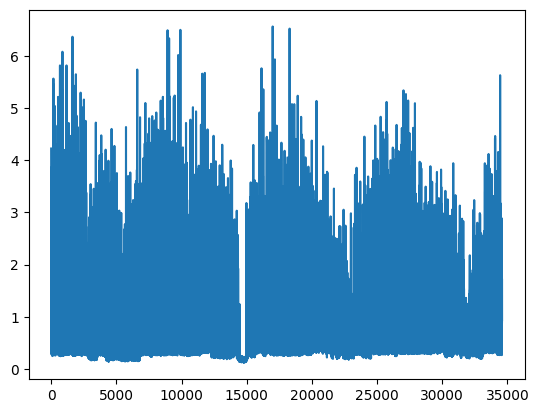

In [6]:
power_hourly = df['Global_active_power']
power_hourly.plot()

power_hourly.shape

In [7]:
def df_to_X_y(df, window_size = 5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
# power_hourly = hourly_mean 
X,y = df_to_X_y(df =power_hourly, window_size=WINDOW_SIZE)
print(f'X shape:{X.shape}')
print(f'Y shape {y.shape}')

X shape:(34584, 5, 1)
Y shape (34584,)


In [9]:
print(f'X[0]: {X[0]}, y[0]: {y[0]}')
print(f'X[1]: {X[1]}, y[1]: {y[1]}')
print(f'X[2]: {X[2]}, y[2]: {y[2]}')

X[0]: [[4.22288889]
 [3.6322    ]
 [3.40023333]
 [3.26856667]
 [3.05646667]], y[0]: 2.200133333333333
X[1]: [[3.6322    ]
 [3.40023333]
 [3.26856667]
 [3.05646667]
 [2.20013333]], y[1]: 2.0616
X[2]: [[3.40023333]
 [3.26856667]
 [3.05646667]
 [2.20013333]
 [2.0616    ]], y[2]: 1.8824666666666665


In [10]:
def train_test_val_split_series(X: pd.Series, y: pd.Series, train_size = 0.7, val_size = 0.15):
  train_split = int(len(X) * train_size)
  val_split = int(len(X) * (train_size + val_size))

  X_train = X[:train_split]
  y_train = y[:train_split]

  X_val = X[train_split:val_split]
  y_val = y[train_split:val_split]

  X_test = X[val_split:]
  y_test = y[val_split:]

  return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split_series(X=X, y=y)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')  


# X_train.shape, y_train.shape




X_train shape: (24208, 5, 1)
X_val shape: (5188, 5, 1)
X_test shape: (5188, 5, 1)
y_train shape:(24208,)
y_val shape: (5188,)
y_test shape: (5188,)


In [12]:
###Implement test model

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
cp = ModelCheckpoint('model1/checkpoint.models.keras', save_best_only = True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])


In [14]:
# model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs = 10,verbose = 2)

In [ ]:
history = model1.fit(X_train[:128], y_train[:128],
                     validation_data=(X_val[:128], y_val[:128]),
                     epochs=1, verbose=2)
print("Done ✅")